In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/911.csv', nrows=50000)

In [ ]:
df

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1
...,...,...,...,...,...,...,...,...,...
49995,40.052428,-75.120794,CHELTENHAM AVE & WALNUT PARK DR; CHELTENHAM; ...,19012.0,EMS: HEMORRHAGING,2016-04-18 13:21:55,CHELTENHAM,CHELTENHAM AVE & WALNUT PARK DR,1
49996,40.254768,-75.660459,SHOEMAKER RD & ROBINSON ST; POTTSTOWN; 2016-04...,19464.0,Traffic: VEHICLE ACCIDENT -,2016-04-18 13:21:27,POTTSTOWN,SHOEMAKER RD & ROBINSON ST,1
49997,40.069832,-75.316295,CONSHOHOCKEN STATE RD & SCHUYLKILL EXPY OVERPA...,NaN,Fire: RESCUE - ELEVATOR,2016-04-18 13:30:04,WEST CONSHOHOCKEN,CONSHOHOCKEN STATE RD & SCHUYLKILL EXPY OVERPASS,1
49998,40.289027,-75.399590,HARLEYSVILLE PIKE & MAIN ST; LOWER SALFORD; S...,19438.0,EMS: RESPIRATORY EMERGENCY,2016-04-18 13:35:02,LOWER SALFORD,HARLEYSVILLE PIKE & MAIN ST,1


### drop last column as it has just one constant value of 1

In [ ]:
df.drop('e', axis=1, inplace=True)

### zip code has 6204 null values and twp has 18

In [ ]:
df.isna().sum()

lat             0
lng             0
desc            0
zip          6204
title           0
timeStamp       0
twp            18
addr            0
dtype: int64

## Visualization to show the behaviour of data

In [ ]:
df['Reason'] = df['title'].apply(lambda title: title.split(':')[0])

In [ ]:
df['Reason'].value_counts()

EMS        24479
Traffic    18099
Fire        7422
Name: Reason, dtype: int64

### There are 3 reasons to call 911 and highest number of calls received is because of EMS reason

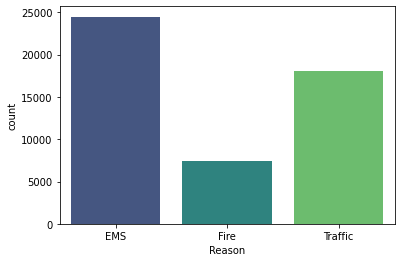

In [ ]:
sns.countplot(x='Reason',data=df,palette='viridis')

### formatting date and time

In [ ]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df['year'] = df['timeStamp'].apply(lambda x: x.year)
df['month'] = df['timeStamp'].apply(lambda x: x.month)
df['day'] = df['timeStamp'].apply(lambda x: x.day)
df['hour'] = df['timeStamp'].apply(lambda x: x.hour)
df['minute'] = df['timeStamp'].apply(lambda x: x.minute)
df['second'] = df['timeStamp'].apply(lambda x: x.second)
df = df.drop('timeStamp', axis=1)

### most of the days has EMS with highest calls and on day 23 has highest traffic calls 

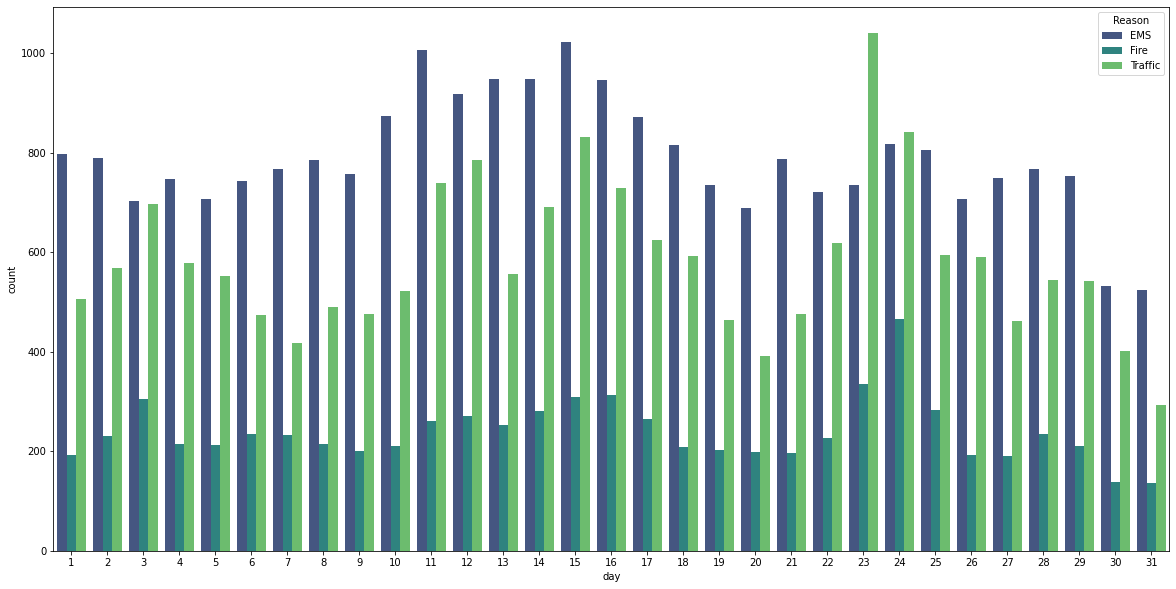

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x='day',data=df,hue='Reason',palette='viridis')

### distribution according to month

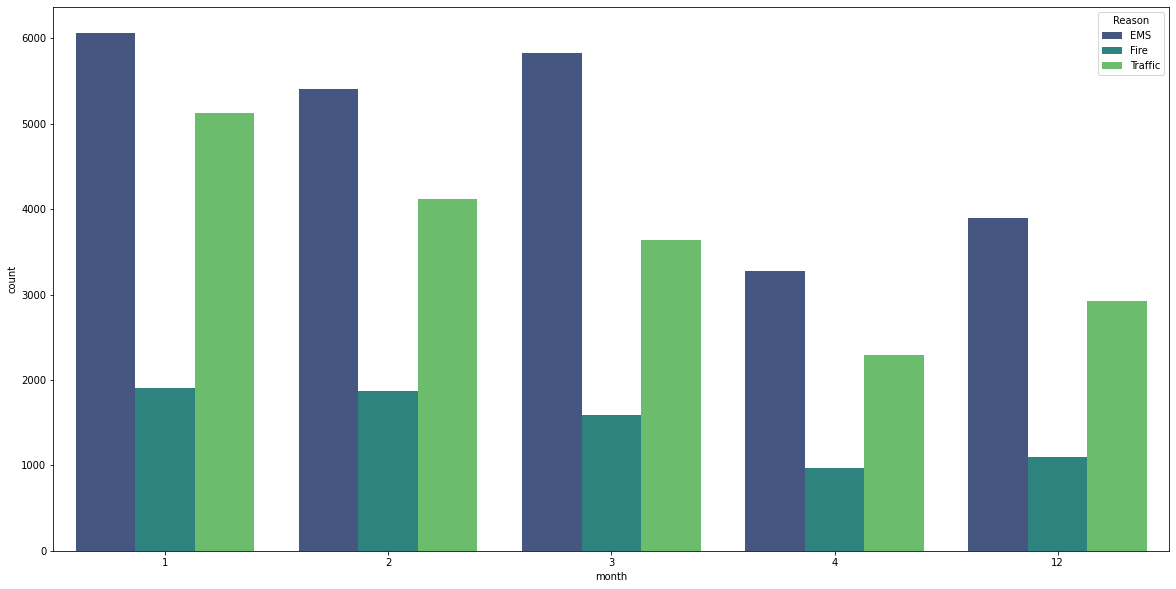

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x='month',data=df,hue='Reason',palette='viridis')

In [ ]:
hours = df.groupby(by=['day','hour']).count()['Reason'].unstack()

### Darker the colour more are the cases, therefore according to figure below at hours 12AM to 5:30 AM everyday there are alot of complaints registered. On the other hand, at 11AM to 6:30PM there are least mainly on 10th to 23rd day of each month.

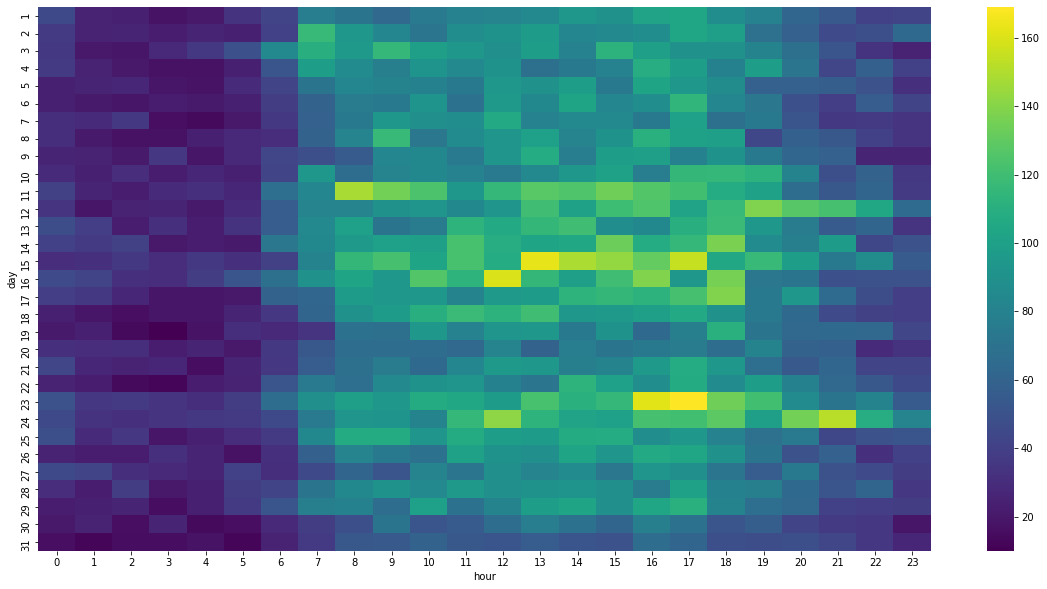

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(hours,cmap='viridis')

### Tokenizing words

https://keras.io/guides/preprocessing_layers/

In [ ]:
vocab_length = 50000

In [ ]:
tokenizer = Tokenizer(num_words = vocab_length)
tokenizer.fit_on_texts(df['desc'])
seq_desc = tokenizer.texts_to_sequences(df['desc'])
maxlen_seq = np.max([len(sequence) for sequence in seq_desc])
    
seq_desc = pad_sequences(seq_desc, maxlen = maxlen_seq, padding ='post')

In [ ]:
#seq_desc

In [ ]:
tokenizer.fit_on_texts(df['addr'])
seq_addr = tokenizer.texts_to_sequences(df['addr'])
maxlen_seq = np.max([len(sequence) for sequence in seq_addr]) 
  
seq_addr = pad_sequences(seq_addr, maxlen = maxlen_seq, padding ='post')

### applying one hot encoding

https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [ ]:
data = ['zip', 'twp']
replacements = ['z', 't']

In [ ]:
for x, y in zip(data, replacements):
  dummies = pd.get_dummies(df[x], prefix = replacements) 
  df = pd.concat([df, dummies], axis=1)
  df = df.drop(x, axis=1)

### splitting the *data*

In [ ]:
df.drop(['desc', 'addr'], axis=1, inplace=True)

In [ ]:
df['type'] = df['title'].apply(lambda x: re.search(r'^\w+', x).group(0))
df = df.drop('title', axis=1)

In [ ]:
x = df.drop('type', axis=1)
y = df['type']

In [ ]:
x

,lat,lng,Reason,year,month,day,hour,minute,second,"['z', 't']_17752.0","['z', 't']_18036.0","['z', 't']_18041.0","['z', 't']_18054.0","['z', 't']_18056.0","['z', 't']_18070.0","['z', 't']_18073.0","['z', 't']_18074.0","['z', 't']_18076.0","['z', 't']_18092.0","['z', 't']_18914.0","['z', 't']_18915.0","['z', 't']_18927.0","['z', 't']_18932.0","['z', 't']_18936.0","['z', 't']_18951.0","['z', 't']_18960.0","['z', 't']_18964.0","['z', 't']_18966.0","['z', 't']_18969.0","['z', 't']_18974.0","['z', 't']_18976.0","['z', 't']_19001.0","['z', 't']_19002.0","['z', 't']_19003.0","['z', 't']_19004.0","['z', 't']_19006.0","['z', 't']_19009.0","['z', 't']_19010.0","['z', 't']_19012.0","['z', 't']_19025.0",...,"['z', 't']_LOWER POTTSGROVE","['z', 't']_LOWER PROVIDENCE","['z', 't']_LOWER SALFORD","['z', 't']_MARLBOROUGH","['z', 't']_MONTGOMERY","['z', 't']_NARBERTH","['z', 't']_NEW HANOVER","['z', 't']_NORRISTOWN","['z', 't']_NORTH WALES","['z', 't']_PENNSBURG","['z', 't']_PERKIOMEN","['z', 't']_PHILA COUNTY","['z', 't']_PLYMOUTH","['z', 't']_POTTSTOWN","['z', 't']_RED HILL","['z', 't']_ROCKLEDGE","['z', 't']_ROYERSFORD","['z', 't']_SALFORD","['z', 't']_SCHWENKSVILLE","['z', 't']_SKIPPACK","['z', 't']_SOUDERTON","['z', 't']_SPRINGFIELD","['z', 't']_TELFORD","['z', 't']_TOWAMENCIN","['z', 't']_TRAPPE","['z', 't']_UPPER DUBLIN","['z', 't']_UPPER FREDERICK","['z', 't']_UPPER GWYNEDD","['z', 't']_UPPER HANOVER","['z', 't']_UPPER MERION","['z', 't']_UPPER MORELAND","['z', 't']_UPPER POTTSGROVE","['z', 't']_UPPER PROVIDENCE","['z', 't']_UPPER SALFORD","['z', 't']_WEST CONSHOHOCKEN","['z', 't']_WEST NORRITON","['z', 't']_WEST POTTSGROVE","['z', 't']_WHITEMARSH","['z', 't']_WHITPAIN","['z', 't']_WORCESTER"
0,40.297876,-75.581294,EMS,2015,12,10,17,10,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40.258061,-75.264680,EMS,2015,12,10,17,29,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40.121182,-75.351975,Fire,2015,12,10,14,39,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40.116153,-75.343513,EMS,2015,12,10,16,47,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40.251492,-75.603350,EMS,2015,12,10,16,56,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,40.052428,-75.120794,EMS,2016,4,18,13,21,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49996,40.254768,-75.660459,Traffic,2016,4,18,13,21,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49997,40.069832,-75.316295,Fire,2016,4,18,13,30,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
49998,40.289027,-75.399590,EMS,2016,4,18,13,35,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


mapping the data to fit it in the model.

In [ ]:
type_map = {'EMS':0, 'Traffic':1, 'Fire':2}
y = y.replace(type_map)

In [ ]:
x = x.drop('Reason', axis=1)

scaling the data for better results

In [ ]:
scaler_vals = StandardScaler()
x = pd.DataFrame(scaler_vals.fit_transform(x), columns=x.columns)

In [ ]:
x

,lat,lng,year,month,day,hour,minute,second,"['z', 't']_17752.0","['z', 't']_18036.0","['z', 't']_18041.0","['z', 't']_18054.0","['z', 't']_18056.0","['z', 't']_18070.0","['z', 't']_18073.0","['z', 't']_18074.0","['z', 't']_18076.0","['z', 't']_18092.0","['z', 't']_18914.0","['z', 't']_18915.0","['z', 't']_18927.0","['z', 't']_18932.0","['z', 't']_18936.0","['z', 't']_18951.0","['z', 't']_18960.0","['z', 't']_18964.0","['z', 't']_18966.0","['z', 't']_18969.0","['z', 't']_18974.0","['z', 't']_18976.0","['z', 't']_19001.0","['z', 't']_19002.0","['z', 't']_19003.0","['z', 't']_19004.0","['z', 't']_19006.0","['z', 't']_19009.0","['z', 't']_19010.0","['z', 't']_19012.0","['z', 't']_19025.0","['z', 't']_19027.0",...,"['z', 't']_LOWER POTTSGROVE","['z', 't']_LOWER PROVIDENCE","['z', 't']_LOWER SALFORD","['z', 't']_MARLBOROUGH","['z', 't']_MONTGOMERY","['z', 't']_NARBERTH","['z', 't']_NEW HANOVER","['z', 't']_NORRISTOWN","['z', 't']_NORTH WALES","['z', 't']_PENNSBURG","['z', 't']_PERKIOMEN","['z', 't']_PHILA COUNTY","['z', 't']_PLYMOUTH","['z', 't']_POTTSTOWN","['z', 't']_RED HILL","['z', 't']_ROCKLEDGE","['z', 't']_ROYERSFORD","['z', 't']_SALFORD","['z', 't']_SCHWENKSVILLE","['z', 't']_SKIPPACK","['z', 't']_SOUDERTON","['z', 't']_SPRINGFIELD","['z', 't']_TELFORD","['z', 't']_TOWAMENCIN","['z', 't']_TRAPPE","['z', 't']_UPPER DUBLIN","['z', 't']_UPPER FREDERICK","['z', 't']_UPPER GWYNEDD","['z', 't']_UPPER HANOVER","['z', 't']_UPPER MERION","['z', 't']_UPPER MORELAND","['z', 't']_UPPER POTTSGROVE","['z', 't']_UPPER PROVIDENCE","['z', 't']_UPPER SALFORD","['z', 't']_WEST CONSHOHOCKEN","['z', 't']_WEST NORRITON","['z', 't']_WEST POTTSGROVE","['z', 't']_WHITEMARSH","['z', 't']_WHITPAIN","['z', 't']_WORCESTER"
0,1.481139,-1.627002,-2.305715,2.223811,-0.669445,0.696652,-1.120381,1.297162,-0.004472,-0.006325,-0.063531,-0.057013,-0.008945,-0.025699,-0.090142,-0.068571,-0.057013,-0.01265,-0.027939,-0.033185,-0.006325,-0.010001,-0.052608,-0.008945,-0.017323,-0.114408,-0.020981,-0.083233,-0.046092,-0.02409,-0.124236,-0.174894,-0.104195,-0.109274,-0.155131,-0.022809,-0.11707,-0.073547,-0.072019,-0.135235,...,-0.134543,-0.187208,-0.117857,-0.057715,-0.171278,-0.050263,10.997782,-0.25470,-0.053556,-0.063372,-0.068571,-0.020498,-0.176707,-0.20787,-0.058236,-0.047382,-0.074503,-0.039528,-0.051644,-0.090816,-0.067083,-0.148723,-0.072856,-0.127353,-0.05522,-0.161046,-0.060108,-0.120532,-0.079878,-0.23354,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
1,1.050821,0.336056,-2.305715,2.223811,-0.669445,0.696652,-0.025644,-0.496784,-0.004472,-0.006325,-0.063531,-0.057013,-0.008945,-0.025699,-0.090142,-0.068571,-0.057013,-0.01265,-0.027939,-0.033185,-0.006325,-0.010001,-0.052608,-0.008945,-0.017323,-0.114408,-0.020981,-0.083233,-0.046092,-0.02409,-0.124236,-0.174894,-0.104195,-0.109274,-0.155131,-0.022809,-0.11707,-0.073547,-0.072019,-0.135235,...,-0.134543,-0.187208,-0.117857,-0.057715,-0.171278,-0.050263,-0.090927,-0.25470,-0.053556,-0.063372,-0.068571,-0.020498,-0.176707,-0.20787,-0.058236,-0.047382,-0.074503,-0.039528,-0.051644,-0.090816,-0.067083,-0.148723,-0.072856,-0.127353,-0.05522,-0.161046,-0.060108,-0.120532,-0.079878,-0.23354,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
2,-0.428581,-0.205190,-2.305715,2.223811,-0.669445,0.169809,0.550533,-0.496784,-0.004472,-0.006325,-0.063531,-0.057013,-0.008945,-0.025699,-0.090142,-0.068571,-0.057013,-0.01265,-0.027939,-0.033185,-0.006325,-0.010001,-0.052608,-0.008945,-0.017323,-0.114408,-0.020981,-0.083233,-0.046092,-0.02409,-0.124236,-0.174894,-0.104195,-0.109274,-0.155131,-0.022809,-0.11707,-0.073547,-0.072019,-0.135235,...,-0.134543,-0.187208,-0.117857,-0.057715,-0.171278,-0.050263,-0.090927,3.92619,-0.053556,-0.063372,-0.068571,-0.020498,-0.176707,-0.20787,-0.058236,-0.047382,-0.074503,-0.039528,-0.051644,-0.090816,-0.067083,-0.148723,-0.072856,-0.127353,-0.05522,-0.161046,-0.060108,-0.120532,-0.079878,

### splitting the data into train and test datasets

In [ ]:
x_train, x_test, desc_train, desc_test, addr_train, addr_test, y_train, y_test = \
    train_test_split(x, seq_desc, seq_addr, y, train_size=0.7, random_state=1)

In [ ]:
np.asarray(desc_train).shape[0]

35000

In [ ]:
print(x_train.shape)
addr_train.shape

(35000, 174)


(35000, 14)

http://man.hubwiz.com/docset/TensorFlow.docset/Contents/Resources/Documents/api_docs/python/tf/keras/models/Model.html

https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/09_sequence_keras/sinemodel/model.py

In [ ]:
import keras

https://www.mygreatlearning.com/blog/keras-tutorial/

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          22400       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 24)]         0                                            
_______________________________________________________________________________________

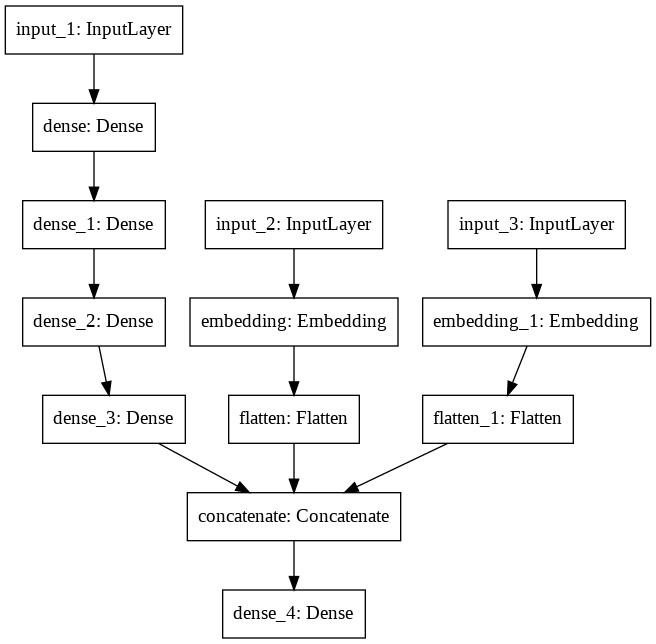

In [ ]:
x_inputs = tf.keras.Input(shape=(x_train.shape[1],))
desc_inputs = tf.keras.Input(shape=(desc_train.shape[1],))
addr_inputs = tf.keras.Input(shape=(addr_train.shape[1],))

# X_inputs
X_dense1 = tf.keras.layers.Dense(128, activation='relu')(x_inputs)
X_dense2 = tf.keras.layers.Dense(128, activation='relu')(X_dense1)
X_dense3 = tf.keras.layers.Dense(128, activation='relu')(X_dense2)
X_dense4 = tf.keras.layers.Dense(128, activation='relu')(X_dense3)

# desc_inputs
desc_embedding = tf.keras.layers.Embedding(
    input_dim=5000,
    output_dim=64,
    input_length=desc_train.shape[0]
)(desc_inputs)
desc_flatten = tf.keras.layers.Flatten()(desc_embedding)

# addr_inputs
addr_embedding = tf.keras.layers.Embedding(
    input_dim=5000,
    output_dim=64,
    input_length=addr_train.shape[0]
)(addr_inputs)
addr_flatten = tf.keras.layers.Flatten()(addr_embedding)

# Using Concatenate library.
concat = tf.keras.layers.concatenate([X_dense4, desc_flatten, addr_flatten])

# Reference: https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)


model = tf.keras.Model(inputs=[x_inputs, desc_inputs, addr_inputs], outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [ ]:
desc_train

array([[187,  14, 734, ...,   0,   0,   0],
       [433,   2,  37, ...,   0,   0,   0],
       [ 55,  96,  91, ...,   0,   0,   0],
       ...,
       [101,   2,  94, ...,   0,   0,   0],
       [670, 764, 126, ...,   0,   0,   0],
       [107,  14, 269, ...,   0,   0,   0]], dtype=int32)

In [ ]:
addr_train

array([[167,   9, 707, ...,   0,   0,   0],
       [403,   1,  19, ...,   0,   0,   0],
       [ 38,  72,  47, ...,   0,   0,   0],
       ...,
       [ 61,   1,  87, ...,   0,   0,   0],
       [637, 739,  82, ...,   0,   0,   0],
       [ 68,   9, 247, ...,   0,   0,   0]], dtype=int32)

training 

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


conv_model = model.fit(
    [x_train, desc_train, addr_train],
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/20
875/875 [==============================] - 8s 9ms/step - loss: 0.1284 - accuracy: 0.9585 - val_loss: 0.0098 - val_accuracy: 0.9987
Epoch 2/20
875/875 [==============================] - 8s 9ms/step - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0045 - val_accuracy: 0.9991
Epoch 3/20
875/875 [==============================] - 8s 9ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0044 - val_accuracy: 0.9993
Epoch 4/20
875/875 [==============================] - 8s 9ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0026 - val_accuracy: 0.9996
Epoch 5/20
875/875 [==============================] - 8s 9ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0028 - val_accuracy: 0.9994
Epoch 6/20
875/875 [==============================] - 8s 9ms/step - loss: 5.9333e-04 - accuracy: 0.9999 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 7/20
875/875 [==============================] - 8s 9ms/step - loss: 1.2718e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.999

In [ ]:
val_accuracy = conv_model.history['val_accuracy']
val_loss  = conv_model.history['val_loss']
epochs = [i for i in range (1,21)]

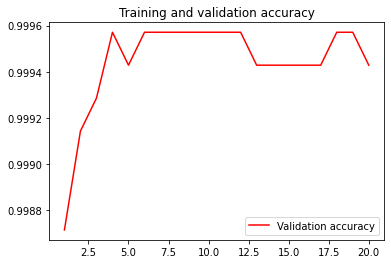

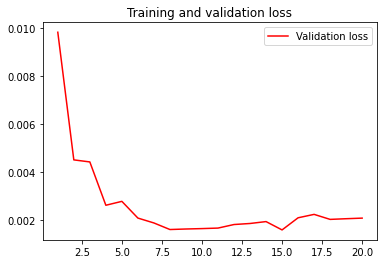

In [ ]:
plt.plot(epochs, cnn_val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.savefig('Accuracy values')
plt.legend()

plt.figure()
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss values')
plt.show()